<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Loading-bulk-datasets" data-toc-modified-id="Loading-bulk-datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Loading bulk datasets</a></span><ul class="toc-item"><li><span><a href="#Regions-in-the-dataset" data-toc-modified-id="Regions-in-the-dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Regions in the dataset</a></span></li><li><span><a href="#Co2-dataset" data-toc-modified-id="Co2-dataset-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Co2 dataset</a></span></li><li><span><a href="#Elec-dataset" data-toc-modified-id="Elec-dataset-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Elec dataset</a></span></li></ul></li><li><span><a href="#Computing-MEFs" data-toc-modified-id="Computing-MEFs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Computing MEFs</a></span><ul class="toc-item"><li><span><a href="#Examples-with-the-MISO-BA" data-toc-modified-id="Examples-with-the-MISO-BA-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Examples with the MISO BA</a></span></li><li><span><a href="#Examples-with-the-CAISO-BA" data-toc-modified-id="Examples-with-the-CAISO-BA-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Examples with the CAISO BA</a></span></li></ul></li><li><span><a href="#Comparison-of-average-MEFs-for-every-BA" data-toc-modified-id="Comparison-of-average-MEFs-for-every-BA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Comparison of average MEFs for every BA</a></span></li><li><span><a href="#A-draft-of-an-hourly-regression-scheme" data-toc-modified-id="A-draft-of-an-hourly-regression-scheme-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>A draft of an hourly regression scheme</a></span><ul class="toc-item"><li><span><a href="#Example-with-MISO" data-toc-modified-id="Example-with-MISO-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Example with MISO</a></span></li><li><span><a href="#Example-with-CISO" data-toc-modified-id="Example-with-CISO-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Example with CISO</a></span></li></ul></li></ul></div>

# Description

In this notebook, I have implemented a rapid prototype for estimating marginal emissions from raw data. The data was downloaded from the following link: web.stanford.edu/~jdechale/emissions_app/. 

Datasets are included within the .zip archive sent alongside the document. 

**A quick note on the structure of the datasets:**

The columns of both datasets have specific names. They are usually a combination of 
- Balacing Authorities ID (e.g. CISO) 
- A tag explaining what we are looking at:
    - D: Demand
    - NG: Net Generation
    - TI: Total Interchange - (positive if exports)
    - ID: Interchange with directly connected balancing authorities - (positive
        if exports)
- For electricity, the type of generation. 

# Load

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

from utils import plot_mef, get_BAs, compute_mef

In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
# replace with your own folder containing the documents

DATA_PATH = '/Users/lucasfuentes/Documents/Ideas/EnergyNetworks/Data'

# Loading bulk datasets

In [61]:
fnm_co2 = os.path.join(DATA_PATH, 'EBA_co2.csv')
fnm_elec = os.path.join(DATA_PATH, 'EBA_elec.csv')

In [62]:
df_co2 = pd.read_csv(fnm_co2, index_col=0, parse_dates=True)

df_elec = pd.read_csv(fnm_elec, index_col=0, parse_dates=True)

## Regions in the dataset

In [63]:
BAs = get_BAs(df_co2)

In [64]:
print("These are the names of the Balancing Authorities present in the dataset:")
print(BAs)
print(f"\nThere are {len(BAs)} BAs.")

These are the names of the Balancing Authorities present in the dataset:
['AEC' 'AECI' 'AESO' 'AVA' 'AVRN' 'AZPS' 'BANC' 'BCHA' 'BPAT' 'CEN' 'CFE'
 'CHPD' 'CISO' 'CPLE' 'CPLW' 'DEAA' 'DOPD' 'DUK' 'EEI' 'EPE' 'ERCO' 'FMPP'
 'FPC' 'FPL' 'GCPD' 'GRID' 'GRIF' 'GRMA' 'GVL' 'GWA' 'HGMA' 'HQT' 'HST'
 'IESO' 'IID' 'IPCO' 'ISNE' 'JEA' 'LDWP' 'LGEE' 'MHEB' 'MISO' 'NBSO'
 'NEVP' 'NSB' 'NWMT' 'NYIS' 'OVEC' 'PACE' 'PACW' 'PGE' 'PJM' 'PNM' 'PSCO'
 'PSEI' 'SC' 'SCEG' 'SCL' 'SEC' 'SEPA' 'SOCO' 'SPA' 'SPC' 'SRP' 'SWPP'
 'TAL' 'TEC' 'TEPC' 'TIDC' 'TPWR' 'TVA' 'WACM' 'WALC' 'WAUW' 'WWA' 'YAD']

There are 76 BAs.


## Co2 dataset

As an example, the first column above gives the CO2-emissions exchanged between AEC and MISO. 

In [49]:
df_co2.head()

,CO2_AEC-MISO_ID,CO2_AEC-SOCO_ID,CO2_AECI-MISO_ID,CO2_AECI-SPA_ID,CO2_AECI-SWPP_ID,CO2_AECI-TVA_ID,CO2_AECI_D,CO2_AECI_NG,CO2_AECI_TI,CO2_AEC_D,...,CO2_WAUW_TI,CO2_WWA-NWMT_ID,CO2_WWA_D,CO2_WWA_NG,CO2_WWA_TI,CO2_YAD-CPLE_ID,CO2_YAD-DUK_ID,CO2_YAD_D,CO2_YAD_NG,CO2_YAD_TI
2018-07-01 00:00:00+00:00,53910.238614,126306.850701,48503.471201,-37853.314031,-68931.442144,149948.065955,2.502421e+06,2.594088e+06,91666.780981,557943.249171,...,-30200.475593,723.813327,11.999932,735.813259,723.813327,151.158440,574.929449,9.949614,736.037503,726.087889
2018-07-01 01:00:00+00:00,55659.969400,126785.749731,179851.395724,-44656.587903,-120554.448912,134517.096720,2.417334e+06,2.566492e+06,149157.455629,543170.037659,...,-33694.861584,769.276024,32.297701,801.573724,769.276024,169.238679,555.354051,10.685742,735.278472,724.592730
2018-07-01 02:00:00+00:00,54917.238769,100362.721240,272562.624457,-38508.124120,-176875.202815,143666.755049,2.287646e+06,2.488492e+06,200846.052572,512778.301291,...,-31667.756758,640.314543,16.979630,657.294173,640.314543,153.838800,562.382885,10.409602,726.631287,716.221686
2018-07-01 03:00:00+00:00,48236.292386,88842.372601,183041.374856,-43802.290159,-151062.189597,101097.945637,2.234720e+06,2.323995e+06,89274.840738,475956.787687,...,-27227.491983,882.444633,34.336250,916.780883,882.444633,-5263.112059,4152.423822,1123.102159,12.413922,-1110.688236
2018-07-01 04:00:00+00:00,43002.546305,83812.044113,-37755.463848,-54497.983419,-106821.689055,54144.294122,2.255946e+06,2.111015e+06,-144930.842200,408252.953360,...,-28780.313224,939.536537,71.649462,1011.186000,939.536537,-7998.470516,6877.259843,1125.210673,4.000000,-1121.210673


## Elec dataset

The format of the column name is 
- **EBA.ba_name-ALL.[D,NG,TI].H** for the [demand, net_generation, total_interchange] hourly for BA ba_name
- **EBA.ba_name-other_ba_name.ID.H** for the interchange between ba_name and other_ba_name
- **EBA.ba_name-ALL.NG.SOURCE.H** where **SOURCE** is going to be water, wind, coal, ... for the total generation of a given source

In [17]:
df_elec.head()

,EBA.AEC-ALL.D.H,EBA.AEC-ALL.NG.COL.H,EBA.AEC-ALL.NG.H,EBA.AEC-ALL.NG.NG.H,EBA.AEC-ALL.NG.OTH.H,EBA.AEC-ALL.NG.WAT.H,EBA.AEC-ALL.TI.H,EBA.AEC-MISO.ID.H,EBA.AEC-SOCO.ID.H,EBA.AECI-ALL.D.H,...,EBA.WWA-ALL.NG.H,EBA.WWA-ALL.NG.WND.H,EBA.WWA-ALL.TI.H,EBA.WWA-NWMT.ID.H,EBA.YAD-ALL.D.H,EBA.YAD-ALL.NG.H,EBA.YAD-ALL.NG.WAT.H,EBA.YAD-ALL.TI.H,EBA.YAD-CPLE.ID.H,EBA.YAD-DUK.ID.H
2018-07-01 00:00:00+00:00,852.088828,395.589543,1127.315688,726.630120,4.048013,1.048013,275.226860,82.331513,192.895347,3736.834955,...,61.317772,61.317772,60.317777,60.317777,2.487404,184.009376,184.009376,181.521972,37.789610,143.732362
2018-07-01 01:00:00+00:00,821.171036,399.680353,1096.994682,691.092041,4.111144,2.111144,275.823646,84.147415,191.676231,3509.233553,...,66.797810,66.797810,64.106335,64.106335,2.671435,183.819618,183.819618,181.148183,42.309670,138.838513
2018-07-01 02:00:00+00:00,762.904264,381.317775,993.927580,607.992727,3.617078,1.000000,231.023316,81.705087,149.318229,3265.266416,...,54.774514,54.774514,53.359545,53.359545,2.602400,181.657822,181.657822,179.055421,38.459700,140.595721
2018-07-01 03:00:00+00:00,707.077333,351.154277,910.720225,555.557480,3.008468,1.000000,203.642892,71.659423,131.983469,3231.656110,...,76.398407,76.398407,73.537053,73.537053,3.170032,3.103481,3.103481,-0.066552,-11.787050,11.720499
2018-07-01 04:00:00+00:00,641.677343,266.336549,840.999966,569.729487,3.466965,1.466965,199.322623,67.589859,131.732764,3175.450535,...,84.265500,84.265500,78.294711,78.294711,3.293148,1.000000,1.000000,-2.293148,-22.420788,20.127640


For instance, for **MISO**, we see that it exchanges with a bunch of BAs. We also know that it produces nuclear, oil, sun, hydro, wind, and "others"

In [18]:
for c in df_elec.columns:
    if 'MISO-' in c:
        print(c)

EBA.MISO-AEC.ID.H
EBA.MISO-AECI.ID.H
EBA.MISO-ALL.D.H
EBA.MISO-ALL.NG.COL.H
EBA.MISO-ALL.NG.H
EBA.MISO-ALL.NG.NG.H
EBA.MISO-ALL.NG.NUC.H
EBA.MISO-ALL.NG.OIL.H
EBA.MISO-ALL.NG.OTH.H
EBA.MISO-ALL.NG.SUN.H
EBA.MISO-ALL.NG.WAT.H
EBA.MISO-ALL.NG.WND.H
EBA.MISO-ALL.TI.H
EBA.MISO-EEI.ID.H
EBA.MISO-IESO.ID.H
EBA.MISO-LGEE.ID.H
EBA.MISO-MHEB.ID.H
EBA.MISO-PJM.ID.H
EBA.MISO-SOCO.ID.H
EBA.MISO-SPA.ID.H
EBA.MISO-SWPP.ID.H
EBA.MISO-TVA.ID.H


# Computing MEFs

In the simplest models, MEFs $\alpha$ can be computed as
$$
\Delta E \propto \alpha \Delta X,
$$
where: 
- $E$ are the total emissions
- $X$ is an appropriate regressor (total generation, fossil fuel generation, demand...). 

I implemented a simple linear regression as a first prototype. 

## Examples with the MISO BA

Below, we compute the MEF for the MISO BA for different regressors. A discussion of these different figures is provided in the main text. 

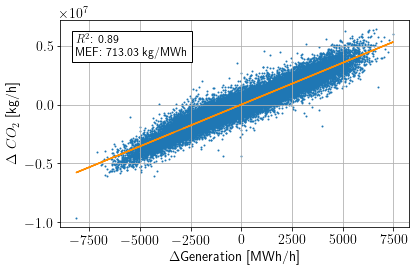

In [140]:
ba = 'MISO'

(ba_, ba_co2), mef, r2 = plot_mef(ba, df_elec, df_co2, which='generation')

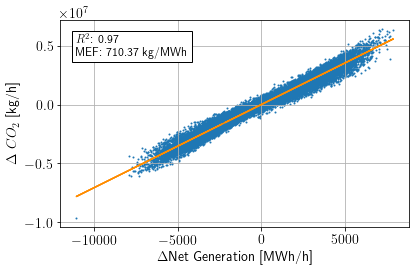

In [123]:
ba = 'MISO'

_ = plot_mef(ba, df_elec, df_co2, which='net_generation')

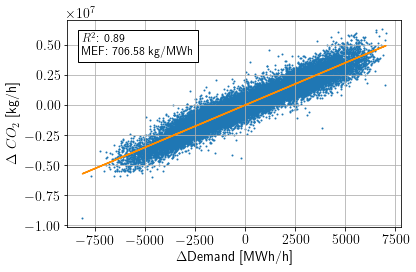

In [124]:
ba = 'MISO'

_ = plot_mef(ba, df_elec, df_co2, which='demand')

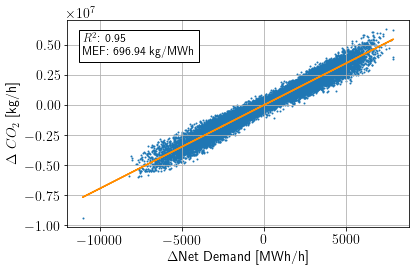

In [125]:
ba = 'MISO'

_ = plot_mef(ba, df_elec, df_co2, which='net_demand')

## Examples with the CAISO BA

Below, we compute the MEF for the MISO BA for different regressors. A discussion of these different figures is provided in the main text. 

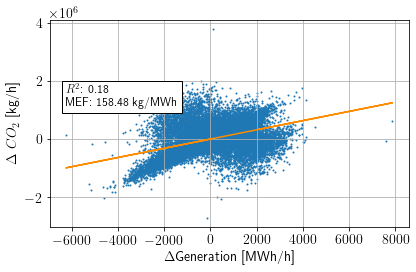

In [126]:
ba = 'CISO'

_ = plot_mef(ba, df_elec, df_co2, which='generation')

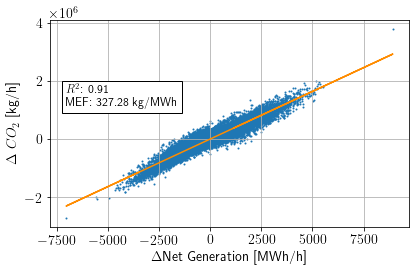

In [127]:
ba = 'CISO'

_ = plot_mef(ba, df_elec, df_co2, which='net_generation')

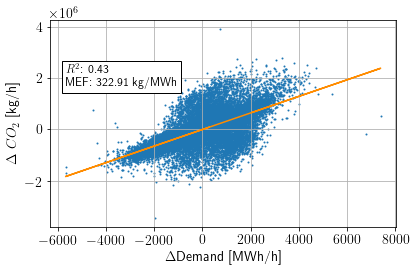

In [128]:
ba = 'CISO'

_ = plot_mef(ba, df_elec, df_co2, which='demand')

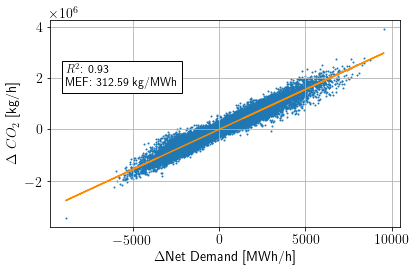

In [129]:
ba = 'CISO'

_ = plot_mef(ba, df_elec, df_co2, which='net_demand')

# Comparison of average MEFs for every BA

We can apply the above methodology across all BAs, to obtain an overview of the distribution of MEFs. 

In [177]:
from utils import get_mef_distribution

In [178]:
which="generation"

In [179]:
BAs, mefs, r2s = get_mef_distribution(df_elec, df_co2, which=which)

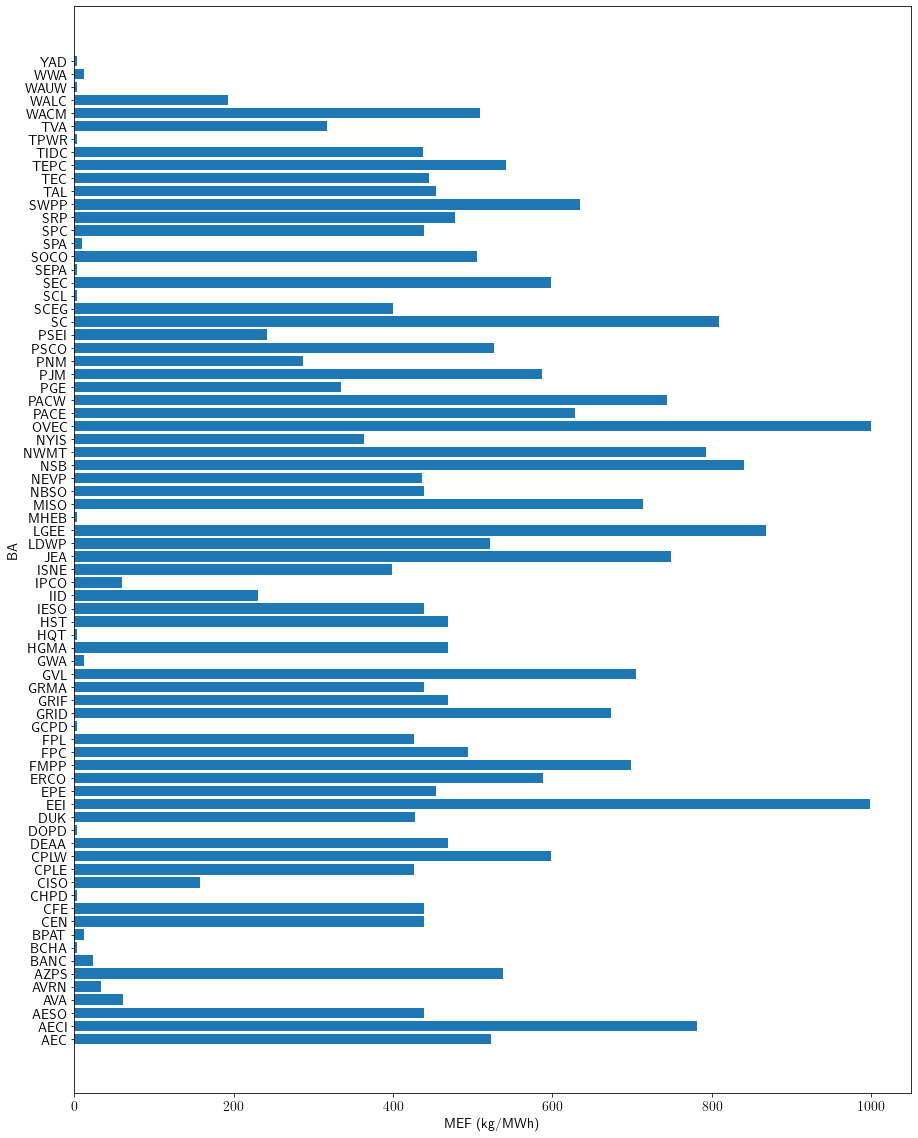

In [182]:
plt.figure(figsize=(15, 20))
plt.barh(BAs, mefs)
plt.xlabel("MEF (kg/MWh)")
plt.ylabel("BA")
plt.savefig(os.path.join("figs", f"mefs_ALL_{which}.pdf"))

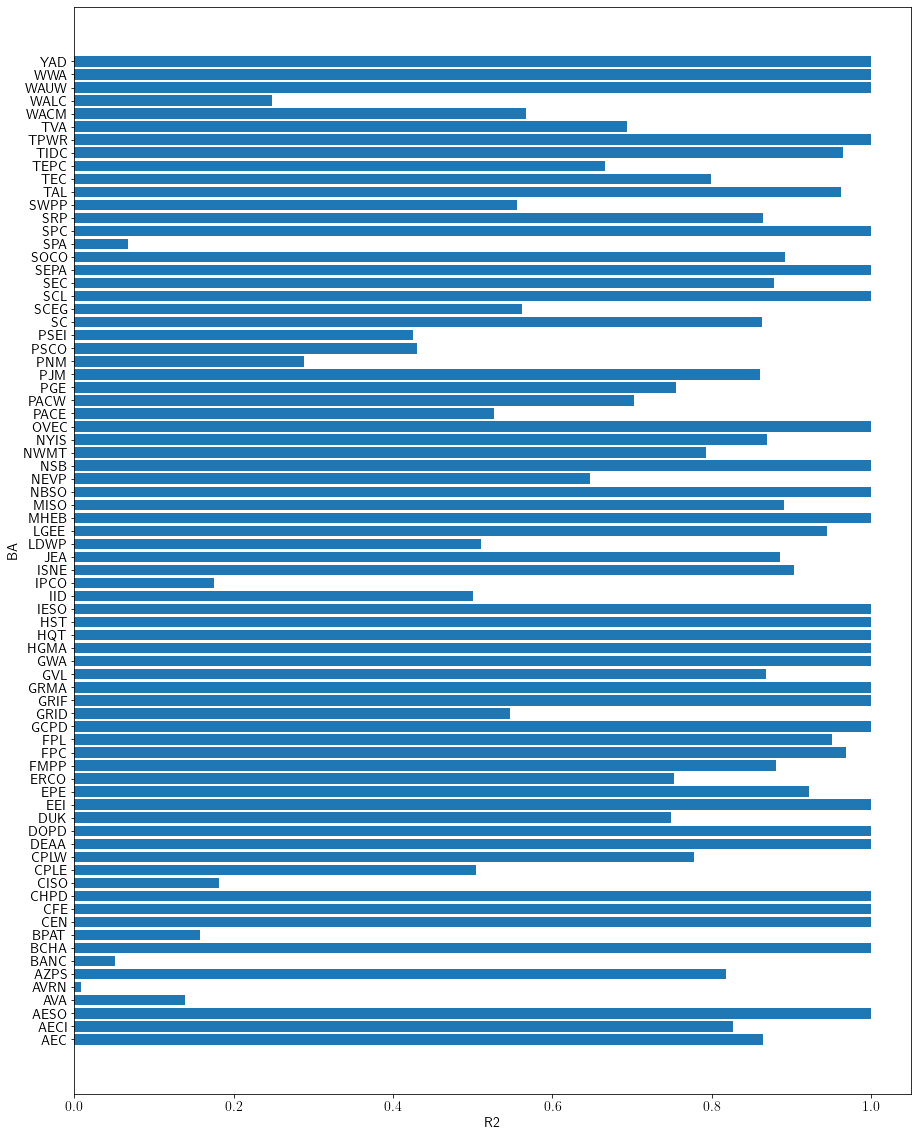

In [183]:
plt.figure(figsize=(15, 20))
plt.barh(BAs, r2s)
plt.xlabel("R2")
plt.ylabel("BA")
plt.savefig(os.path.join("figs", f"R2_ALL_{which}.pdf"))

# A draft of an hourly regression scheme

In [156]:
from utils import compute_hourly_mef

## Example with MISO

In [199]:
ba = 'MISO'

In [200]:
mefs_hr_G, r2s_hr_G = compute_hourly_mef(ba, df_elec, df_co2, which='generation')

mefs_hr_ND, r2s_hr_ND = compute_hourly_mef(ba, df_elec, df_co2, which='net_demand')

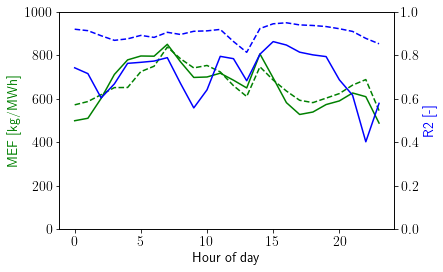

In [201]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(mefs_hr_G, 'g-')
ax2.plot(r2s_hr_G, 'b-')
ax1.plot(mefs_hr_ND, 'g--')
ax2.plot(r2s_hr_ND, 'b--')

ax1.set_xlabel('Hour of day')
ax1.set_ylabel('MEF [kg/MWh]', color='g')
ax2.set_ylabel('R2 [-]', color='b')
ax1.set_ylim([0, 1000])
ax2.set_ylim([0, 1])

plt.savefig(os.path.join("figs", f"{ba}_hourly.pdf"));

## Example with CISO

In [187]:
ba = 'CISO'

In [188]:
mefs_hr_G, r2s_hr_G = compute_hourly_mef(ba, df_elec, df_co2, which='generation')

mefs_hr_ND, r2s_hr_ND = compute_hourly_mef(ba, df_elec, df_co2, which='net_demand')

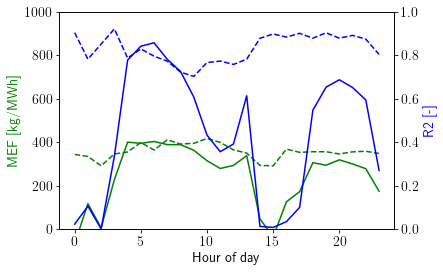

In [196]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(mefs_hr_G, 'g-')
ax2.plot(r2s_hr_G, 'b-')
ax1.plot(mefs_hr_ND, 'g--')
ax2.plot(r2s_hr_ND, 'b--')

ax1.set_xlabel('Hour of day')
ax1.set_ylabel('MEF [kg/MWh]', color='g')
ax2.set_ylabel('R2 [-]', color='b')
ax1.set_ylim([0, 1000])
ax2.set_ylim([0, 1])

plt.savefig(os.path.join("figs", f"{ba}_hourly.pdf"));